<a href="https://colab.research.google.com/github/kdidi99/ml_heidelberg/blob/main/qda_lda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Team members:

*   Rudolf Braun
*   Jannik Schacht
*   Kieran Didi

# 1. Data preparation

In [51]:
from sklearn.datasets import load_digits
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection

In [52]:
digits = load_digits() 
digits.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [53]:
data = digits["data"]
images = digits["images"]
target = digits["target"]
target_names = digits["target_names"]

Data filtering (indeed we have 361 instances with a dimension of 8x8=64 each)



In [54]:
X_all = data
y_all = target

X_filter = X_all[np.logical_or(1 == y_all, 7 == y_all)]
y_filter = y_all[np.logical_or(1 == y_all, 7 == y_all)]
X_filter.shape

(361, 64)

Split into training and test set

In [55]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_filter, y_filter,
   test_size = 0.4, random_state = 0)

Visualize a few numbers to make sure we have the correct images

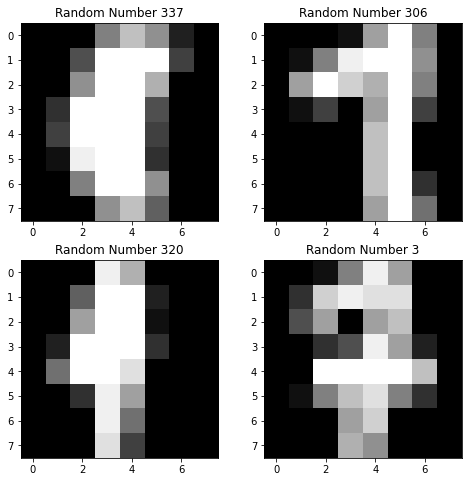

In [56]:
fig, axs = plt.subplots(2, 2)
sel = np.random.randint(low=0, high=361, size=4)
for r, x, y in zip(sel, [0, 0, 1, 1], [0, 1, 0, 1]):
    img = X_filter[r, :].reshape((8,8))
    assert 2 == len(img.shape)
    axs[x, y].imshow(img, interpolation="nearest", cmap="gray")
    axs[x, y].set_title(f"Random Number {r}")
fig.set_size_inches(8, 8)

# 1.1 Dimension Reduction

Look at the values of pixels in different instances

In [57]:
#separate 7's and 1's
X_one = X_filter[1 == y_filter]
X_seven = X_filter[7 == y_filter]

#calculate the means of each pixel in the respective classes and take the difference 
mean_diff = X_one.mean(axis=0)-X_seven.mean(axis=0)

#look for the top 5 pixels most bright for 1's and 7's respectively
idx_one = (mean_diff).argsort()[:5]
idx_seven = (-mean_diff).argsort()[:5]

print(idx_one)
print(mean_diff[idx_one])
print(idx_seven)
print(mean_diff[idx_seven])

[10 29 37  5 30]
[-6.46479219 -6.08244828 -5.82485113 -4.95100988 -4.69332065]
[19 60 61 27 52]
[12.5387071  10.82076862  8.56574989  8.03431764  7.7054147 ]


The first two pixels in each case seem to make the biggest difference, so we choose a linear combination of those pixels ($p_{xx}$) as our features:      
$f_1 = p_{10} + p_{29}$ <br>
$f_2 = p_{19} + p_{60}$

In [103]:
def reduce_dim(x):
    #define indices to be selected
    idx_1 = np.array([19, 60])
    idx_7 = np.array([10, 29])

    #select entries via indices and calculate new features from them
    x_1 = np.sum(x.take(idx_1, axis=1), axis=1)
    x_7 = np.sum(x.take(idx_7, axis=1), axis=1)
    #reduced_x = x.take(idx, axis=1)
    #combine the two features into one array
    reduced_x = np.column_stack((x_1, x_7))
    return reduced_x


In [116]:
reduced_x = reduce_dim(X_filter)
reduced_x.shape

(361, 2)

# 1.2 Scatterplot

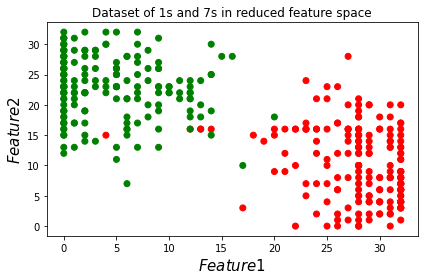

In [122]:
#plt.style.use('_mpl-gallery')
fig, ax = plt.subplots()
color= ['red' if y == 1 else 'green' for y in y_filter]
ax.scatter(reduced_x[:,0], reduced_x[:,1], c=color)

ax.set_xlabel(r'$Feature 1$', fontsize=15)
ax.set_ylabel(r'$Feature 2$', fontsize=15)
ax.set_title('Dataset of 1s and 7s in reduced feature space')

fig.tight_layout()
plt.show()

The two classes don't overlap too much, but are present as two separate clusters as visualised in the plot above. From this we can conclude that the reduced features are informative enough to continue.